#Multi-head Attention in Pytorch

https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
https://pytorch.org/docs/stable/_modules/torch/nn/modules/activation.html#MultiheadAttention

In [ ]:
class MultiheadAttention(Module):
    r"""Allows the model to jointly attend to information
    from different representation subspaces.
    See `Attention Is All You Need <https://arxiv.org/abs/1706.03762>`_

    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O

    where :math:`head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)`.

    Args:
        embed_dim: total dimension of the model.
        num_heads: parallel attention heads.
        dropout: a Dropout layer on attn_output_weights. Default: 0.0.
        bias: add bias as module parameter. Default: True.
        add_bias_kv: add bias to the key and value sequences at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        kdim: total number of features in key. Default: None.
        vdim: total number of features in value. Default: None.
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).

    Note that if :attr:`kdim` and :attr:`vdim` are None, they will be set
    to :attr:`embed_dim` such that query, key, and value have the same
    number of features.

    Examples::

        >>> multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)
    """
    __constants__ = ['batch_first']
    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False,
                 kdim=None, vdim=None, batch_first=False, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_first = batch_first
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        if self._qkv_same_embed_dim is False:
            self.q_proj_weight = Parameter(torch.empty((embed_dim, embed_dim), **factory_kwargs))
            self.k_proj_weight = Parameter(torch.empty((embed_dim, self.kdim), **factory_kwargs))
            self.v_proj_weight = Parameter(torch.empty((embed_dim, self.vdim), **factory_kwargs))
            self.register_parameter('in_proj_weight', None)
        else:
            self.in_proj_weight = Parameter(torch.empty((3 * embed_dim, embed_dim), **factory_kwargs))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)

        if bias:
            self.in_proj_bias = Parameter(torch.empty(3 * embed_dim, **factory_kwargs))
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj = NonDynamicallyQuantizableLinear(embed_dim, embed_dim, bias=bias, **factory_kwargs)

        if add_bias_kv:
            self.bias_k = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
            self.bias_v = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            xavier_uniform_(self.in_proj_weight)
        else:
            xavier_uniform_(self.q_proj_weight)
            xavier_uniform_(self.k_proj_weight)
            xavier_uniform_(self.v_proj_weight)

        if self.in_proj_bias is not None:
            constant_(self.in_proj_bias, 0.)
            constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            xavier_normal_(self.bias_v)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super(MultiheadAttention, self).__setstate__(state)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, key_padding_mask: Optional[Tensor] = None,
                need_weights: bool = True, attn_mask: Optional[Tensor] = None) -> Tuple[Tensor, Optional[Tensor]]:
        r"""
    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. When given a binary mask and a value is True,
            the corresponding value on the attention layer will be ignored. When given
            a byte mask and a value is non-zero, the corresponding value on the attention
            layer will be ignored
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.

    Shapes for inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, L, E)` if ``batch_first`` is ``True``.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, S, E)` if ``batch_first`` is ``True``.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, S, E)` if ``batch_first`` is ``True``.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a ByteTensor is provided, the non-zero positions will be ignored while the position
          with the zero positions will be unchanged. If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: if a 2D mask: :math:`(L, S)` where L is the target sequence length, S is the
          source sequence length.

          If a 3D mask: :math:`(N\cdot\text{num\_heads}, L, S)` where N is the batch size, L is the target sequence
          length, S is the source sequence length. ``attn_mask`` ensure that position i is allowed to attend
          the unmasked positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
          while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
          is not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.

    Shapes for outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension. :math:`(N, L, E)` if ``batch_first`` is ``True``.
        - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
          L is the target sequence length, S is the source sequence length.
        """
        if self.batch_first:
            query, key, value = [x.transpose(1, 0) for x in (query, key, value)]

        if not self._qkv_same_embed_dim:
            attn_output, attn_output_weights = F.multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight)
        else:
            attn_output, attn_output_weights = F.multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask)
        if self.batch_first:
            return attn_output.transpose(1, 0), attn_output_weights
        else:
            return attn_output, attn_output_weights

class PReLU(Module):
    r"""Applies the element-wise function:

    .. math::
        \text{PReLU}(x) = \max(0,x) + a * \min(0,x)

    or

    .. math::
        \text{PReLU}(x) =
        \begin{cases}
        x, & \text{ if } x \geq 0 \\
        ax, & \text{ otherwise }
        \end{cases}

    Here :math:`a` is a learnable parameter. When called without arguments, `nn.PReLU()` uses a single
    parameter :math:`a` across all input channels. If called with `nn.PReLU(nChannels)`,
    a separate :math:`a` is used for each input channel.


    .. note::
        weight decay should not be used when learning :math:`a` for good performance.

    .. note::
        Channel dim is the 2nd dim of input. When input has dims < 2, then there is
        no channel dim and the number of channels = 1.

    Args:
        num_parameters (int): number of :math:`a` to learn.
            Although it takes an int as input, there is only two values are legitimate:
            1, or the number of channels at input. Default: 1
        init (float): the initial value of :math:`a`. Default: 0.25

    Shape:
        - Input: :math:`(N, *)` where `*` means, any number of additional
          dimensions
        - Output: :math:`(N, *)`, same shape as the input

    Attributes:
        weight (Tensor): the learnable weights of shape (:attr:`num_parameters`).

    .. image:: ../scripts/activation_images/PReLU.png

    Examples::

        >>> m = nn.PReLU()
        >>> input = torch.randn(2)
        >>> output = m(input)
    """
    __constants__ = ['num_parameters']
    num_parameters: int

    def __init__(self, num_parameters: int = 1, init: float = 0.25,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        self.num_parameters = num_parameters
        super(PReLU, self).__init__()
        self.weight = Parameter(torch.empty(num_parameters, **factory_kwargs).fill_(init))

    def forward(self, input: Tensor) -> Tensor:
        return F.prelu(input, self.weight)

    def extra_repr(self) -> str:
        return 'num_parameters={}'.format(self.num_parameters)

https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py

In [ ]:
def multi_head_attention_forward(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    embed_dim_to_check: int,
    num_heads: int,
    in_proj_weight: Tensor,
    in_proj_bias: Optional[Tensor],
    bias_k: Optional[Tensor],
    bias_v: Optional[Tensor],
    add_zero_attn: bool,
    dropout_p: float,
    out_proj_weight: Tensor,
    out_proj_bias: Optional[Tensor],
    training: bool = True,
    key_padding_mask: Optional[Tensor] = None,
    need_weights: bool = True,
    attn_mask: Optional[Tensor] = None,
    use_separate_proj_weight: bool = False,
    q_proj_weight: Optional[Tensor] = None,
    k_proj_weight: Optional[Tensor] = None,
    v_proj_weight: Optional[Tensor] = None,
    static_k: Optional[Tensor] = None,
    static_v: Optional[Tensor] = None,
) -> Tuple[Tensor, Optional[Tensor]]:
    r"""
    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        embed_dim_to_check: total dimension of the model.
        num_heads: parallel attention heads.
        in_proj_weight, in_proj_bias: input projection weight and bias.
        bias_k, bias_v: bias of the key and value sequences to be added at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        dropout_p: probability of an element to be zeroed.
        out_proj_weight, out_proj_bias: the output projection weight and bias.
        training: apply dropout if is ``True``.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. This is an binary mask. When the value is True,
            the corresponding value on the attention layer will be filled with -inf.
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.
        use_separate_proj_weight: the function accept the proj. weights for query, key,
            and value in different forms. If false, in_proj_weight will be used, which is
            a combination of q_proj_weight, k_proj_weight, v_proj_weight.
        q_proj_weight, k_proj_weight, v_proj_weight, in_proj_bias: input projection weight and bias.
        static_k, static_v: static key and value used for attention operators.
    Shape:
        Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a ByteTensor is provided, the non-zero positions will be ignored while the zero positions
          will be unchanged. If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensures that position i is allowed to attend the unmasked
          positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
          while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
          are not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - static_k: :math:`(N*num_heads, S, E/num_heads)`, where S is the source sequence length,
          N is the batch size, E is the embedding dimension. E/num_heads is the head dimension.
        - static_v: :math:`(N*num_heads, S, E/num_heads)`, where S is the source sequence length,
          N is the batch size, E is the embedding dimension. E/num_heads is the head dimension.
        Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension.
        - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
          L is the target sequence length, S is the source sequence length.
    """
    tens_ops = (query, key, value, in_proj_weight, in_proj_bias, bias_k, bias_v, out_proj_weight, out_proj_bias)
    if has_torch_function(tens_ops):
        return handle_torch_function(
            multi_head_attention_forward,
            tens_ops,
            query,
            key,
            value,
            embed_dim_to_check,
            num_heads,
            in_proj_weight,
            in_proj_bias,
            bias_k,
            bias_v,
            add_zero_attn,
            dropout_p,
            out_proj_weight,
            out_proj_bias,
            training=training,
            key_padding_mask=key_padding_mask,
            need_weights=need_weights,
            attn_mask=attn_mask,
            use_separate_proj_weight=use_separate_proj_weight,
            q_proj_weight=q_proj_weight,
            k_proj_weight=k_proj_weight,
            v_proj_weight=v_proj_weight,
            static_k=static_k,
            static_v=static_v,
        )

    # set up shape vars
    tgt_len, bsz, embed_dim = query.shape
    ## tgt_len : 문장 수
    ## bsz : 단어 수
    ## embed_dim : 단어의 벡터 차원
    src_len, _, _ = key.shape
    assert embed_dim == embed_dim_to_check, \
        f"was expecting embedding dimension of {embed_dim_to_check}, but got {embed_dim}"
    if isinstance(embed_dim, torch.Tensor):
        # embed_dim can be a tensor when JIT tracing
        head_dim = embed_dim.div(num_heads, rounding_mode='trunc')
    else:
        head_dim = embed_dim // num_heads
    ## 트랜스포머에서 head_dim을 embed_dim/num_heads로 쪼개기로 함
    assert head_dim * num_heads == embed_dim, f"embed_dim {embed_dim} not divisible by num_heads {num_heads}"
    if use_separate_proj_weight:
        # allow MHA to have different embedding dimensions when separate projection weights are used
        assert key.shape[:2] == value.shape[:2], \
            f"key's sequence and batch dims {key.shape[:2]} do not match value's {value.shape[:2]}"
    else:
        assert key.shape == value.shape, f"key shape {key.shape} does not match value shape {value.shape}"

    #
    # compute in-projection
    #
    if not use_separate_proj_weight: ## 이게 기본 세팅
        q, k, v = _in_projection_packed(query, key, value, in_proj_weight, in_proj_bias)
        '''
        def _in_projection_packed(
            q: Tensor,
            k: Tensor,
            v: Tensor,
            w: Tensor,
            b: Optional[Tensor] = None,
        ) :
            if k is v:
                if q is k:
                    # self-attention
                    return linear(q, w, b).chunk(3, dim=-1)
        '''
    else:
        assert q_proj_weight is not None, "use_separate_proj_weight is True but q_proj_weight is None"
        assert k_proj_weight is not None, "use_separate_proj_weight is True but k_proj_weight is None"
        assert v_proj_weight is not None, "use_separate_proj_weight is True but v_proj_weight is None"
        if in_proj_bias is None:
            b_q = b_k = b_v = None
        else:
            b_q, b_k, b_v = in_proj_bias.chunk(3)
        q, k, v = _in_projection(query, key, value, q_proj_weight, k_proj_weight, v_proj_weight, b_q, b_k, b_v)

    ## 미리 메모리 할당한 in_proj_weight, in_proj_bias를 통해 연산, 이 둘은 학습될 예정

    # prep attention mask
    if attn_mask is not None:
        if attn_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            attn_mask = attn_mask.to(torch.bool)
        else:
            assert attn_mask.is_floating_point() or attn_mask.dtype == torch.bool, \
                f"Only float, byte, and bool types are supported for attn_mask, not {attn_mask.dtype}"
        # ensure attn_mask's dim is 3
        if attn_mask.dim() == 2:
            correct_2d_size = (tgt_len, src_len)
            if attn_mask.shape != correct_2d_size:
                raise RuntimeError(f"The shape of the 2D attn_mask is {attn_mask.shape}, but should be {correct_2d_size}.")
            attn_mask = attn_mask.unsqueeze(0)
        elif attn_mask.dim() == 3:
            correct_3d_size = (bsz * num_heads, tgt_len, src_len)
            if attn_mask.shape != correct_3d_size:
                raise RuntimeError(f"The shape of the 3D attn_mask is {attn_mask.shape}, but should be {correct_3d_size}.")
        else:
            raise RuntimeError(f"attn_mask's dimension {attn_mask.dim()} is not supported")

    # prep key padding mask
    if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
        warnings.warn("Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
        key_padding_mask = key_padding_mask.to(torch.bool)

    # add bias along batch dimension (currently second)
    if bias_k is not None and bias_v is not None:
        assert static_k is None, "bias cannot be added to static key."
        assert static_v is None, "bias cannot be added to static value."
        k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
        v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))
    else:
        assert bias_k is None
        assert bias_v is None

    #
    # reshape q, k, v for multihead attention and make em batch first
    #
    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    if static_k is None: ## 기본값
        k = k.contiguous().view(k.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
    else:
        # TODO finish disentangling control flow so we don't do in-projections when statics are passed
        assert static_k.size(0) == bsz * num_heads, \
            f"expecting static_k.size(0) of {bsz * num_heads}, but got {static_k.size(0)}"
        assert static_k.size(2) == head_dim, \
            f"expecting static_k.size(2) of {head_dim}, but got {static_k.size(2)}"
        k = static_k
    if static_v is None: ## 기본값
        v = v.contiguous().view(v.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
    else:
        # TODO finish disentangling control flow so we don't do in-projections when statics are passed
        assert static_v.size(0) == bsz * num_heads, \
            f"expecting static_v.size(0) of {bsz * num_heads}, but got {static_v.size(0)}"
        assert static_v.size(2) == head_dim, \
            f"expecting static_v.size(2) of {head_dim}, but got {static_v.size(2)}"
        v = static_v

    # add zero attention along batch dimension (now first)
    if add_zero_attn:
        zero_attn_shape = (bsz * num_heads, 1, head_dim)
        k = torch.cat([k, torch.zeros(zero_attn_shape, dtype=k.dtype, device=k.device)], dim=1)
        v = torch.cat([v, torch.zeros(zero_attn_shape, dtype=v.dtype, device=v.device)], dim=1)
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))

    # update source sequence length after adjustments
    src_len = k.size(1)

    # merge key padding and attention masks
    if key_padding_mask is not None:
        assert key_padding_mask.shape == (bsz, src_len), \
            f"expecting key_padding_mask shape of {(bsz, src_len)}, but got {key_padding_mask.shape}"
        key_padding_mask = key_padding_mask.view(bsz, 1, 1, src_len).   \
            expand(-1, num_heads, -1, -1).reshape(bsz * num_heads, 1, src_len)
        if attn_mask is None:
            attn_mask = key_padding_mask
        elif attn_mask.dtype == torch.bool:
            attn_mask = attn_mask.logical_or(key_padding_mask)
        else:
            attn_mask = attn_mask.masked_fill(key_padding_mask, float("-inf"))

    # convert mask to float
    if attn_mask is not None and attn_mask.dtype == torch.bool:
        new_attn_mask = torch.zeros_like(attn_mask, dtype=torch.float)
        new_attn_mask.masked_fill_(attn_mask, float("-inf"))
        attn_mask = new_attn_mask

    # adjust dropout probability
    if not training:
        dropout_p = 0.0

    #
    # (deep breath) calculate attention and out projection
    #
    attn_output, attn_output_weights = _scaled_dot_product_attention(q, k, v, attn_mask, dropout_p) ## 사진3
    ''' _scaled_dot_product_attention :

    B, Nt, E = q.shape
    q = q / math.sqrt(E)
    # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
    attn = torch.bmm(q, k.transpose(-2, -1))
    attn = softmax(attn, dim=-1)
    # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
    output = torch.bmm(attn, v)
    '''
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim) ## 사진2
    attn_output = linear(attn_output, out_proj_weight, out_proj_bias)

    if need_weights:
        # average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        return attn_output, attn_output_weights.sum(dim=1) / num_heads
    else:
        return attn_output, None

참고 이미지(https://wikidocs.net/31379)

사진1  
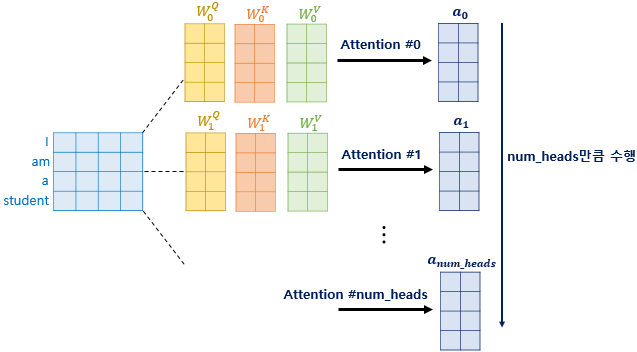


사진2  
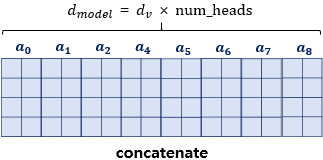

사진3  
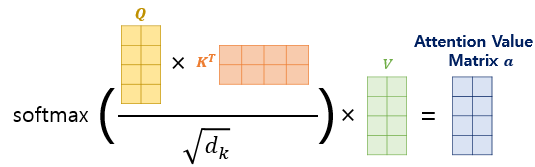